In [1]:

from makiflow.layers import *
from makiflow.models.segmentation.segmentator import Segmentator
from makiflow.tf_scripts import set_main_gpu
set_main_gpu(0)
import tensorflow as tf
import numpy as np
import glob
import cv2
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
from makiflow.models.classificator import Classificator
from makiflow.models import SSDModel, DetectorClassifier
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter

In [2]:
from makiflow.layers import *
from makiflow.models import Classificator

eps= 1.001e-05

def transition_layer(x, dropout_rate, number, compression=1.0):

    assert compression >= 0.0 and compression <= 1.0, f"wrong value for compression: {compression}"

    prefix = f'pool{str(number)}_'

    in_f = x.get_shape()[-1]
    out_f = int(in_f * compression)

    x = BatchNormLayer(D=in_f, eps=eps, name=prefix + 'bn')(x)
    x = ActivationLayer(name=prefix + 'relu')(x)
    x = ConvLayer(kw=1,kh=1,in_f=in_f, out_f=out_f, activation=None, use_bias=False,
            name=prefix + 'conv', padding='VALID')(x)
    if dropout_rate is not None:
        x = DropoutLayer(p_keep=dropout_rate, name=prefix + 'dropout')(x)
    x = AvgPoolLayer(padding='VALID', name=prefix + 'avg_pool')(x)

    return x

# growth rate is k in paper
# filters is L in paper
def bottleneck_layer(x, growth_rate, dropout_rate, stage, block, multiply=4):

    prefix = f'conv{str(stage)}_block{str(block)}_'
    # 0bn 0relu 1conv 1bn 1relu 2conv

    in_f = x.get_shape()[-1]
    growth_f = multiply * growth_rate

    x = BatchNormLayer(D=in_f, eps=eps, name=prefix + '0_bn')(x)
    x = ActivationLayer(name=prefix + '0_relu')(x)
    x = ConvLayer(kw=1,kh=1,in_f=in_f, out_f=growth_f, activation=None, use_bias=False,
            name=prefix + '1_conv', padding='VALID')(x)

    if dropout_rate is not None:
        x = DropoutLayer(p_keep=dropout_rate, name=prefix + '1_dropout')(x)

    x = BatchNormLayer(D=growth_f, eps=eps, name=prefix + '1_bn')(x)
    x = ActivationLayer(name=prefix + '1_relu')(x)
    x = ConvLayer(kw=3,kh=3,in_f=growth_f, out_f=growth_rate, activation=None, use_bias=False,
            name=prefix + '2_conv')(x)

    if dropout_rate is not None:
        x = DropoutLayer(p_keep=dropout_rate, name=prefix + '2_dropout')(x)

    return x

def dense_block(x, nb_layers, stage, growth_rate, dropout_rate):
    concat_layers = x

    for i in range(nb_layers):
        x = bottleneck_layer(x=concat_layers, growth_rate=growth_rate, dropout_rate=dropout_rate, stage=stage, block=i+1)

        concat_layers = ConcatLayer(name=f'conv{stage}_block{i+1}_concat')([concat_layers, x])

    return concat_layers
 
# Dense 121 [6, 12, 24, 16]

# Dense 161 [6, 12, 36, 24]

# Dense 169 [6, 12, 32, 32]

# Dense 201 [6, 12, 48, 32]

# Dense 264 [6, 12, 64, 48]


def DenseNet(batch_size,picture_size, growth_rate, dropout_rate,reduction=0.0, nb_layers=[6, 12, 24, 16]):
    box = []

    compression = 1 - reduction

    in_x = InputLayer(input_shape=[batch_size,picture_size,picture_size,3], name='Input')

    x = ZeroPaddingLayer(padding=[[3,3],[3,3]], name='zero_padding2d_4')(in_x)

    x = ConvLayer(kw=7,kh=7,in_f=3, stride=2, out_f=growth_rate * 2, activation=None, use_bias=False,
            name='conv1/conv', padding='VALID')(x)

    x = BatchNormLayer(D=growth_rate * 2, eps=eps, name='conv1/bn')(x)
    x = ActivationLayer(name='conv1/relu')(x)
    box.append(x)
    x = ZeroPaddingLayer(padding=[[1,1],[1,1]], name='zero_padding2d_5')(x)

    x = MaxPoolLayer(ksize=[1,3,3,1], padding='VALID', name='pool1')(x)

    # densenet blocks
    for block_index in range(len(nb_layers) - 1):
        # dense block
        x = dense_block(x=x, nb_layers=nb_layers[block_index], stage=block_index+2, 
                growth_rate=growth_rate, dropout_rate=dropout_rate)
        box.append(x)
        # transition block
        x = transition_layer(x=x,
             dropout_rate=dropout_rate, number=block_index+2, compression=compression)

    x = dense_block(x=x, nb_layers=nb_layers[-1], stage=len(nb_layers)+1, 
            growth_rate=growth_rate, dropout_rate=dropout_rate)

    x = BatchNormLayer(D=x.get_shape()[-1], eps=eps, name='bn')(x)
    x = ActivationLayer(name='relu')(x)
    #x = GlobalAvgPoolLayer(name='avg_pool')(x)
    # dense part (fc layers)
    #output = DenseLayer(in_d=x.get_shape()[-1], out_d=1000, activation=None, use_bias=True, name="fc1000")(x)

    return in_x, x, box


def DenseUnet(batch_size,picture_size,classes, growth_rate, dropout_rate,reduction=0.0, nb_layers=[6,12,24,16]):

    in_x, x, box = DenseNet(batch_size=batch_size,picture_size=picture_size, growth_rate=growth_rate,
         dropout_rate=dropout_rate,reduction=reduction, nb_layers=nb_layers)

    for i in range(len(box)):
        print(f'size of {i} index box is {box[i].get_shape()[-1]}')

    x = ResizeLayer([shape*2 for shape in x.get_shape()[1:3]],interpolation='nearest_neighbor',name='unet_stage1_resize_1')(x)
    out_f = int(x.get_shape()[-1] / 4)
    x = ConvLayer(kw=1,kh=1,in_f=x.get_shape()[-1], out_f=out_f, activation=None, use_bias=False,
            name='unet_stage1_conv_1')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage1_unet_bn_0')(x) 

    box_f = box[3].get_shape()[-1]
    out_f_skip = int(x.get_shape()[-1] / 4)
    skip = ConvLayer(kw=1,kh=1,in_f=box_f, out_f=out_f_skip, activation=None, use_bias=False,
            name='unet_stage1_conv_pointwise')(box[3])
    skip = BatchNormLayer(D=out_f_skip, eps=eps, name='unet_stage1_unet_bn_0_1')(skip)

    x = ConcatLayer(name='unet_stage1_unet_concate_1')([skip,x])
    out_f = x.get_shape()[-1]
    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage1_unet_conv2')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage1_unet_bn_1')(x)
    x = ActivationLayer(name='unet_stage1_unet_activation_1')(x)

    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage1_unet_conv3')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage1_unet_bn_2')(x)

    x = ResizeLayer([shape*2 for shape in x.get_shape()[1:3]],interpolation='nearest_neighbor',name='unet_stage2_resize_1')(x)

    x = ConvLayer(kw=1,kh=1,in_f=out_f, out_f=int(out_f / 4), activation=None, use_bias=False,
            name='unet_stage2_conv_1')(x)  
    x = BatchNormLayer(D=int(out_f / 4), eps=eps, name='unet_stage2_unet_bn_0')(x)   

    box_f = box[2].get_shape()[-1]
    out_f_skip = int(x.get_shape()[-1] / 2)
    skip = ConvLayer(kw=1,kh=1,in_f=box_f, out_f=out_f_skip, activation=None, use_bias=False,
            name='unet_stage2_conv_pointwise')(box[2])
    skip = BatchNormLayer(D=out_f_skip, eps=eps, name='unet_stage2_unet_bn_0_1')(skip) 

    x = ConcatLayer(name='unet_stage2_unet_concate_1')([skip,x])
    out_f = x.get_shape()[-1]
    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage2_unet_conv2')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage2_unet_bn_1')(x)
    x = ActivationLayer(name='unet_stage2_unet_activation_1')(x)

    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage2_unet_conv3')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage2_unet_bn_2')(x)

    x = ResizeLayer([shape*2 for shape in x.get_shape()[1:3]],interpolation='nearest_neighbor',name='unet_stage3_resize_1')(x)

    x = ConvLayer(kw=1,kh=1,in_f=out_f, out_f=int(out_f / 4), activation=None, use_bias=False,
            name='unet_stage3_conv_1')(x)   
    x = BatchNormLayer(D=int(out_f / 4), eps=eps, name='unet_stage3_unet_bn_0')(x) 

    box_f = box[1].get_shape()[-1]
    out_f_skip = int(x.get_shape()[-1] / 2)
    skip = ConvLayer(kw=1,kh=1,in_f=box_f, out_f=out_f_skip, activation=None, use_bias=False,
            name='unet_stage3_conv_pointwise')(box[1])
    skip = BatchNormLayer(D=out_f_skip, eps=eps, name='unet_stage3_unet_bn_0_1')(skip) 

    x = ConcatLayer(name='unet_stage3_unet_concate_1')([skip,x])
    out_f = x.get_shape()[-1]
    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage3_unet_conv2')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage3_unet_bn_1')(x)
    x = ActivationLayer(name='unet_stage3_unet_activation_1')(x)

    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage3_unet_conv3')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage3_unet_bn_2')(x)

    x = ResizeLayer([shape*2 for shape in x.get_shape()[1:3]],interpolation='nearest_neighbor',name='unet_stage4_resize_1')(x)

    x = ConvLayer(kw=1,kh=1,in_f=out_f, out_f=int(out_f / 2), activation=None, use_bias=False,
            name='unet_stage4_conv_1')(x)  
    x = BatchNormLayer(D=int(out_f / 2), eps=eps, name='unet_stage4_unet_bn_0')(x) 

    box_f = box[0].get_shape()[-1]
    out_f_skip = int(x.get_shape()[-1])
    skip = ConvLayer(kw=1,kh=1,in_f=box_f, out_f=out_f_skip, activation=None, use_bias=False,
            name='unet_stage4_conv_pointwise')(box[0])
    skip = BatchNormLayer(D=out_f_skip, eps=eps, name='unet_stage4_unet_bn_0_1')(skip)

    x = ConcatLayer(name='unet_stage4_unet_concate_1')([skip,x])
    out_f = x.get_shape()[-1]
    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage4_unet_conv2')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage4_unet_bn_1')(x)
    x = ActivationLayer(name='unet_stage4_unet_activation_1')(x)

    x = ConvLayer(kw=3,kh=3,in_f=out_f, out_f=out_f, activation=None, use_bias=False,
            name='unet_stage4_unet_conv3')(x)
    x = BatchNormLayer(D=out_f, eps=eps, name='unet_stage4_unet_bn_2')(x)

    x = ResizeLayer([shape*2 for shape in x.get_shape()[1:3]],interpolation='nearest_neighbor',name='unet_stage5_resize_1')(x)

    x = ConvLayer(kw=1,kh=1,in_f=out_f, out_f=64, activation=None, use_bias=False,
            name='unet_stage5_conv_pointwise')(x)
    x = BatchNormLayer(D=64, eps=eps, name='unet_stage5_unet_bn_0')(x)

    x = ConvLayer(kw=3,kh=3,in_f=64, out_f=64, activation=None, use_bias=False,
            name='unet_stage5_unet_conv1')(x)
    x = BatchNormLayer(D=64, eps=eps, name='unet_stage5_unet_bn_1')(x)
    x = ActivationLayer(name='unet_stage5_unet_activation_1')(x)

    x = ConvLayer(kw=3,kh=3,in_f=64, out_f=64, activation=None, use_bias=False,
            name='unet_stage5_unet_conv2')(x)
    #x = DropoutLayer(p_keep=0.8, name='endo_dropout_stage5')(x)
    x = BatchNormLayer(D=64, eps=eps, name='unet_stage5_unet_bn_2')(x)
    x = ActivationLayer(name='unet_stage5_unet_activation_2')(x)

    x = ConvLayer(kw=1,kh=1,in_f=64, out_f=classes, activation=None, use_bias=False,
            name='prediction')(x)


    return in_x, x


In [3]:
in_x, output = DenseUnet(batch_size=2,picture_size=1024,classes=9, 
                         growth_rate=32, dropout_rate=None,reduction=0.5, nb_layers=[6, 12, 48, 32])

size of 0 index box is 64
size of 1 index box is 256
size of 2 index box is 512
size of 3 index box is 1792


In [4]:
diz = output.get_previous_tensors()
diz.update(output.get_self_pair())
names = []
for name,_ in diz.items():
    names.append(name)

In [5]:
names

['Input',
 'zero_padding2d_4',
 'conv1/conv',
 'conv1/bn',
 'conv1/relu',
 'unet_stage4_conv_pointwise',
 'unet_stage4_unet_bn_0_1',
 'zero_padding2d_5',
 'pool1',
 'conv2_block1_0_bn',
 'conv2_block1_0_relu',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_concat',
 'conv2_block2_0_bn',
 'conv2_block2_0_relu',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_concat',
 'conv2_block3_0_bn',
 'conv2_block3_0_relu',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_concat',
 'conv2_block4_0_bn',
 'conv2_block4_0_relu',
 'conv2_block4_1_conv',
 'conv2_block4_1_bn',
 'conv2_block4_1_relu',
 'conv2_block4_2_conv',
 'conv2_block4_concat',
 'conv2_block5_0_bn',
 'conv2_block5_0_relu',
 'conv2_block5_1_conv',
 'conv2_block5_1_bn',
 'conv2_block5_1_relu',
 'conv2_block5_2_conv',
 'conv2_block5_concat',
 'conv2_block6_0

In [6]:
from makiflow.models.segmentation import Segmentator

In [7]:
model = Segmentator(in_x,output)


In [8]:
import tensorflow as tf
ses = tf.Session()
model.set_session(ses)

In [9]:
model.save_architecture('dense_net_unet_v1_201.json')

Model's architecture is saved to dense_net_unet_v1_201.json.


In [18]:
import numpy as np
a = np.random.randn(2,1024,1024,3)

In [19]:
ses.run(output.get_data_tensor(),feed_dict={in_x.get_data_tensor():a})

array([[[[-2.45254016e+00,  2.56237459e+00, -6.11946249e+00, ...,
          -1.02729397e+01, -6.52005911e+00,  2.33763957e+00],
         [-4.49026078e-01,  3.15555906e+00, -6.84134769e+00, ...,
          -9.66818714e+00, -7.43301010e+00,  2.01071095e+00],
         [-2.15955138e+00,  1.38331270e+00, -5.81533384e+00, ...,
          -7.09788799e+00, -4.31132650e+00,  3.99169016e+00],
         ...,
         [ 1.50675364e+01, -9.23481369e+00, -1.57115192e+01, ...,
          -1.13125396e+00,  2.32430935e+01, -1.04924488e+01],
         [ 1.17639513e+01, -6.76609039e+00, -1.76714687e+01, ...,
          -1.77521038e+00,  1.85197792e+01, -9.57900047e+00],
         [ 1.20220852e+01, -7.02455902e+00, -1.76402493e+01, ...,
          -2.59186172e+00,  1.87535362e+01, -9.69973278e+00]],

        [[-1.05881155e+00,  3.41691351e+00, -5.28829527e+00, ...,
          -1.12718821e+01, -7.00157785e+00,  2.74099731e+00],
         [-4.83774155e-01,  3.67902422e+00, -4.88779354e+00, ...,
          -1.00765314e

In [1]:
import numpy as np

In [2]:
x = np.linspace(0,3.14,100)

In [3]:
x

array([0.        , 0.03171717, 0.06343434, 0.09515152, 0.12686869,
       0.15858586, 0.19030303, 0.2220202 , 0.25373737, 0.28545455,
       0.31717172, 0.34888889, 0.38060606, 0.41232323, 0.4440404 ,
       0.47575758, 0.50747475, 0.53919192, 0.57090909, 0.60262626,
       0.63434343, 0.66606061, 0.69777778, 0.72949495, 0.76121212,
       0.79292929, 0.82464646, 0.85636364, 0.88808081, 0.91979798,
       0.95151515, 0.98323232, 1.01494949, 1.04666667, 1.07838384,
       1.11010101, 1.14181818, 1.17353535, 1.20525253, 1.2369697 ,
       1.26868687, 1.30040404, 1.33212121, 1.36383838, 1.39555556,
       1.42727273, 1.4589899 , 1.49070707, 1.52242424, 1.55414141,
       1.58585859, 1.61757576, 1.64929293, 1.6810101 , 1.71272727,
       1.74444444, 1.77616162, 1.80787879, 1.83959596, 1.87131313,
       1.9030303 , 1.93474747, 1.96646465, 1.99818182, 2.02989899,
       2.06161616, 2.09333333, 2.12505051, 2.15676768, 2.18848485,
       2.22020202, 2.25191919, 2.28363636, 2.31535354, 2.34707

In [4]:
y = np.sin(x)

In [5]:
import matplotlib.pyplot as plt

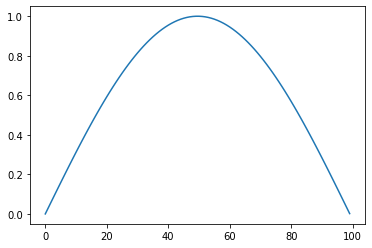

In [37]:
plt.plot(y)


In [38]:
noizeMC = (np.random.randn(100) / 21 ).astype(np.float32)

In [45]:
noizeMCSIN = noizeMC + y 

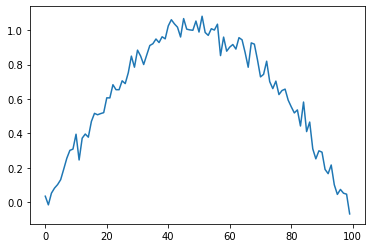

In [46]:
plt.plot(noizeMCSIN)
plt.show()

In [47]:
W = []

In [48]:
starto = 0
for i in range(100):
    starto = starto*0.99 + (1 - 0.99)*noizeMCSIN[i]
    W.append(starto)

In [49]:
W

[0.00033786375075578717,
 0.00016949621693409977,
 0.0006828518564195369,
 0.001485987667569639,
 0.0024855435309770416,
 0.0037609764303364827,
 0.005638658464985048,
 0.00813038294916495,
 0.011057709013368128,
 0.014027074668701697,
 0.01783308473790208,
 0.020102862895909256,
 0.023618310868877168,
 0.02733944071105273,
 0.030842375170165477,
 0.03522728855194977,
 0.04003689099272308,
 0.04471616622424053,
 0.049416065841508094,
 0.054124700271482556,
 0.05964927755131484,
 0.06511388927600545,
 0.07129171074556633,
 0.07711788032322861,
 0.08288433751029099,
 0.08911213565370978,
 0.09511505431317892,
 0.10169332646710047,
 0.10916995222680853,
 0.11592731698971441,
 0.12360884000719176,
 0.1308748924254501,
 0.13757055115515954,
 0.14475812660790108,
 0.15242210755225277,
 0.16011340518834236,
 0.16800197992652277,
 0.17560538698551395,
 0.18346922147430628,
 0.19113319955138358,
 0.1994746062380718,
 0.20809356123483033,
 0.21638440592028604,
 0.22439891084378225,
 0.2317617777

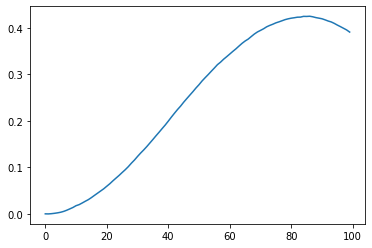

In [50]:
plt.plot(W)
plt.show()